
## Overview

This is a technique outlined in [Leon A. Gatys' paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576), which is a great read, and you should definitely check it out. 

Neural style transfer is an optimization technique used to take three images, a **content** image, a **style reference** image (such as an artwork by a famous painter), and the **input** image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [ ]:
## Enable eager execution
tf.enable_eager_execution()
tf.device('/gpu:0')
print(f'Eager execution: {tf.executing_eagerly()}')

In [45]:
#assign images path
content_path= 'panda.jpg'
style_path = 'picasso_animal.jpg'

In [46]:
def load_img(path):
  max_dim = 512
  img = Image.open(path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img,title=''):
  if len(img.shape)>3:
    out = np.squeeze(img, axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  plt.title = title

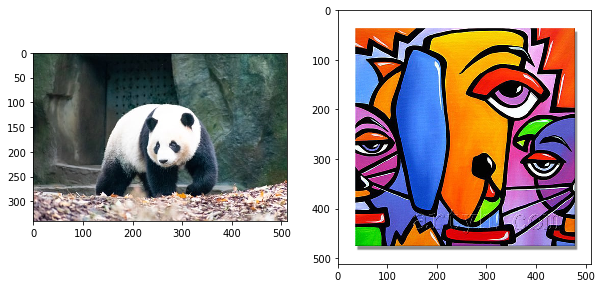

In [47]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

In [48]:
def load_process_img(path):
  img = load_img(path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [49]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [50]:
vgg_model_test = tf.keras.applications.VGG19()
vgg_model_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [51]:
# we will select intermediate layer to perform loss function
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

In [52]:
def get_model_with_selected_layers():

  vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  style_outputs = [ vgg_model.get_layer(name).output for name in style_layers]
  content_outputs = [vgg_model.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(vgg_model.input, model_outputs )

In [53]:
def get_content_loss(gen_content, target):
  return tf.reduce_sum(tf.square(gen_content - target))

In [54]:
def gram_matrix(input_tensor):
  channel = input_tensor.shape[-1]
  a = tf.reshape(input_tensor, [-1,channel])
  n = tf.shape(a)[0]
  gram = tf.matmul(a,a, transpose_b = True)
  return gram/tf.cast(n, float32)

def get_style_cost(gen_style, gram_target):
  return tf.reduce_sum(tf.square(gram_matrix(gen_style) - gram_target))

In [55]:
def feature_extractor(model, content_path, style_path):

  content_image = load_process_img(content_path)
  style_image = load_process_img(style_path)

  style_outputs = model(style_image)
  content_outputs = model(content_image)

  style_features = [layer[0] for layer in style_outputs[:len(style_layers)]]
  content_features = [layer[0] for layer in content_outputs[len(style_layers):]]
  return style_features, content_features

In [56]:
def compute_loss(model, loss_weights, gen_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights

  outputs = model(gen_image)
  style_output_features = outputs[:len(style_layers)]
  content_output_features = outputs[len(style_layers)]

  style_loss = 0.
  content_loss = 0.

  style_layers_weight = 1.0/float(len(style_layers))
  for gen_style, gram_target in zip(style_output_features,gram_style_features):
    style_loss += style_layers_weight * get_style_cost(gen_style[0], gram_target)

  content_layers_weights = 1.0/float(len(content_layers))
  for gen_content, target in zip(content_output_features,content_features):
    content_loss += content_layers_weights * get_content_loss(gen_content[0], target)

  loss = style_score + content_score 

  return loss, style_loss, content_loss

In [57]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [58]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model_with_selected_layers() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = feature_extractor(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss

In [59]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=100)

ResourceExhaustedError: OOM when allocating tensor with shape[262144,262144] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul] name: MatMul/

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [ ]:
show_results(best, content_path, style_path)